# Počítačový návrh léčiv, 8. cvičení
Jiří Reiniš

**Dnes budeme delat MDS.**

In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import SaltRemover
from rdkit.Chem.Draw import IPythonConsole
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
import molvs

from scipy.spatial import distance
from sklearn import manifold
import seaborn
import pandas as pd

In [2]:
isOrganic = Chem.MolFromSmarts("[#6]")
isInorganic = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!Cl;!F;!Br;!I]")

In [3]:
suppl = Chem.SDMolSupplier("../../data/drugbank.sdf")
mols = [m for m in suppl if m]

RDKit WARNING: [14:37:16]  S group DAT ignored on line 2516
RDKit WARNING: [14:37:16]  S group DAT ignored on line 2516
RDKit WARNING: [14:37:16]  S group DAT ignored on line 2516
RDKit WARNING: [14:37:16]  S group DAT ignored on line 2516
RDKit WARNING: [14:37:16]  S group DAT ignored on line 15552
RDKit WARNING: [14:37:16]  S group DAT ignored on line 15552
RDKit WARNING: [14:37:16]  S group DAT ignored on line 15552
RDKit WARNING: [14:37:16]  S group DAT ignored on line 15552
RDKit ERROR: [14:37:16] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [14:37:16] ERROR: Could not sanitize molecule ending on line 20009
RDKit WARNING: [14:37:16] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [14:37:16] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [14:37:16]  S group GEN ignored on line 102860
RDKit ERROR: [14:37:16] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [14:37:16]  Unhand

RDKit ERROR: [14:37:17] ERROR: Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
RDKit ERROR: 
RDKit ERROR: [14:37:17] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 9 10
RDKit ERROR: 
RDKit ERROR: [14:37:17] ERROR: Could not sanitize molecule ending on line 442989
RDKit ERROR: [14:37:17] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 9 10
RDKit ERROR: 
RDKit ERROR: [14:37:17] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9
RDKit ERROR: 
RDKit ERROR: [14:37:17] ERROR: Could not sanitize molecule ending on line 447465
RDKit ERROR: [14:37:17] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9
RDKit ERROR: 
RDKit ERROR: [14:37:17] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit ERROR: 
RDKit ERROR: [14:37:17] ERROR: Could not sanitize molecule ending on line 466177
RDKit ERROR: [14:37:17] ERROR: Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit ERROR: 
RDKit ERROR: [14:37:17] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 17
RDKit ERR

RDKit ERROR: [14:37:17] ERROR: Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [14:37:18]  Unhandled CTAB feature: S group SRU on line: 754017. Molecule skipped.
RDKit ERROR: [14:37:18] Explicit valence for atom # 0 Be, 3, is greater than permitted
RDKit ERROR: [14:37:18] ERROR: Could not sanitize molecule ending on line 995692
RDKit ERROR: [14:37:18] ERROR: Explicit valence for atom # 0 Be, 3, is greater than permitted
RDKit ERROR: [14:37:18]  Unhandled CTAB feature: S group SRU on line: 1148513. Molecule skipped.
RDKit ERROR: [14:37:18] Explicit valence for atom # 0 C greater than permitted
RDKit ERROR: [14:37:18] ERROR: Could not sanitize molecule ending on line 1151592


In [4]:
mol = Chem.MolFromSmiles("[Ca+2].[O-]C([O-])=O")
mol = Chem.MolFromSmiles("O=C(C)Oc1ccccc1C([O-])O")
print(mol.HasSubstructMatch(isOrganic))
print(mol.HasSubstructMatch(isInorganic))

True
False


In [5]:
remover = SaltRemover.SaltRemover()

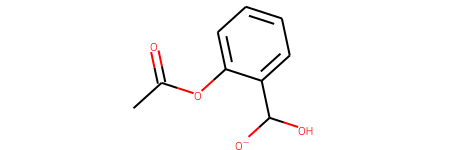

In [6]:
remover.StripMol(mol)

Z (http://rdkit.org/docs/Cookbook.html) si zkopirujeme funkci na odstraneni naboju

In [7]:
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    if replaced:
        return mol
    else:
        return False

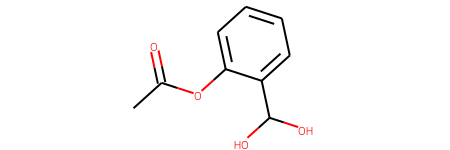

In [8]:
NeutraliseCharges(remover.StripMol(mol))

In [9]:
isOrganic = Chem.MolFromSmarts("[#6]")
hasInorganic = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!Cl;!F;!Br;!I]")

_s = molvs.Standardizer()

def standardization(mol):
    mol = _s.standardize(mol)
    mol = _s.fragment_parent(mol)
    if mol.HasSubstructMatch(isOrganic) and not mol.HasSubstructMatch(hasInorganic):
        mol = _s.charge_parent(mol)
        mol = _s.stereo_parent(mol)
 
    if mol.HasSubstructMatch(isOrganic) and not mol.HasSubstructMatch(hasInorganic):
        return mol
    else:
        return None

In [10]:
drugbank = [mol for mol in  Chem.SDMolSupplier("../../data/drugbank.sdf") if mol]
supp = (standardization(mol) for mol in drugbank if mol)

clean_drugbank = [mol for mol in supp if mol]


RDKit WARNING: [14:37:19]  S group DAT ignored on line 2516
RDKit WARNING: [14:37:19]  S group DAT ignored on line 2516
RDKit WARNING: [14:37:19]  S group DAT ignored on line 2516
RDKit WARNING: [14:37:19]  S group DAT ignored on line 2516
RDKit WARNING: [14:37:19]  S group DAT ignored on line 15552
RDKit WARNING: [14:37:19]  S group DAT ignored on line 15552
RDKit WARNING: [14:37:19]  S group DAT ignored on line 15552
RDKit WARNING: [14:37:19]  S group DAT ignored on line 15552
RDKit ERROR: [14:37:18] ERROR: Explicit valence for atom # 0 C greater than permitted
RDKit ERROR: [14:37:19] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [14:37:19] ERROR: Could not sanitize molecule ending on line 20009
RDKit WARNING: [14:37:19] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [14:37:19] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [14:37:19]  S group GEN ignored on line 102860
RDKit ERROR: [14:37:19] ERROR: Explici

RDKit ERROR: [14:37:20] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 8 9 10
RDKit ERROR: 
RDKit ERROR: [14:37:20] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9
RDKit ERROR: 
RDKit ERROR: [14:37:20] ERROR: Could not sanitize molecule ending on line 447465
RDKit ERROR: [14:37:20] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9
RDKit ERROR: 
RDKit ERROR: [14:37:20] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit ERROR: 
RDKit ERROR: [14:37:20] ERROR: Could not sanitize molecule ending on line 466177
RDKit ERROR: [14:37:20] ERROR: Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit ERROR: 
RDKit ERROR: [14:37:20] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 17
RDKit ERROR: 
RDKit ERROR: [14:37:20] ERROR: Could not sanitize molecule ending on line 468852
RDKit ERROR: [14:37:20] ERROR: Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 17
RDKit ERROR: 
RDKit ERROR: [14:37:20] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
RDKit ERRO

RDKit ERROR: [14:37:20] ERROR: Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [14:37:20]  Unhandled CTAB feature: S group SRU on line: 754017. Molecule skipped.
RDKit ERROR: [14:37:21] Explicit valence for atom # 0 Be, 3, is greater than permitted
RDKit ERROR: [14:37:21] ERROR: Could not sanitize molecule ending on line 995692
RDKit ERROR: [14:37:21] ERROR: Explicit valence for atom # 0 Be, 3, is greater than permitted
RDKit ERROR: [14:37:21]  Unhandled CTAB feature: S group SRU on line: 1148513. Molecule skipped.
RDKit ERROR: [14:37:21] Explicit valence for atom # 0 C greater than permitted
RDKit ERROR: [14:37:21] ERROR: Could not sanitize molecule ending on line 1151592
RDKit ERROR: [14:37:21] ERROR: Explicit valence for atom # 0 C greater than permitted
RDKit ERROR: [14:38:49] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 
RDKit ERROR: [14:38:49] Can't kekulize mol.  Unkekulized atoms: 3 10
RDKit ERROR: 
RDKit ERROR: [14:38:49] Ca

In [11]:
len(clean_drugbank)

6207

In [12]:
fps = [Chem.GetMorganFingerprintAsBitVect(m,2, nBits=1024) for m in clean_drugbank]

sparse_mat = distance.pdist(fps, metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

clf = manifold.MDS(n_components=2, n_init=2, max_iter=100, dissimilarity='precomputed')
X_mds = clf.fit_transform(dist_mat)

In [13]:
data = pd.DataFrame(X_mds, columns=["x", "y"])

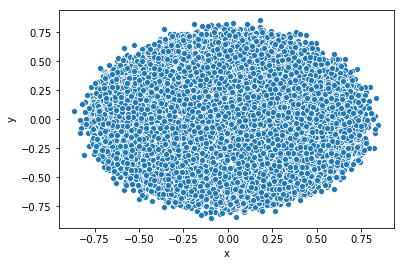

In [14]:
seaborn.scatterplot(x="x", y = "y", data=data)

In [15]:
def distance_function(i, j):
    return dist_mat[i,j]

In [16]:
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(fps), 20, seed=666))

t_data = data.copy()
t_data["picked"] = [x in picked for x,y in enumerate(X_mds)]

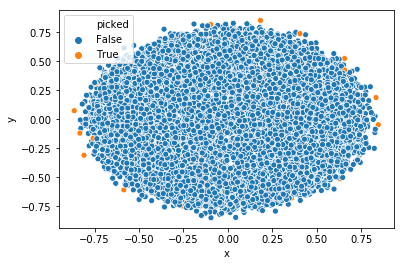

In [17]:
seaborn.scatterplot(x="x", y = "y", data=t_data, hue="picked")